<a href="https://colab.research.google.com/github/marlonrcfranco/weather-guru/blob/main/weather_guru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# weather-guru
## Will it rain tomorrow?


### Goal 🌦
Implement an algorithm that performs **next day rain prediction** by training machine learning models on the target variable `RainTomorrow`.



### Dataset 📂
The dataset contains about **10 years of daily weather observations** from various locations in **Australia**.

**`RainTomorrow`** is the target variable to be  predicted. It means - it rained the next day, this column is `Yes` if the rain that day was 1mm or more.







## Imports & Defines

In [1]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
# Paralelism
from numba import vectorize,jit,njit

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import mean_squared_error, accuracy_score
#from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Masking
#from tensorflow.keras.models import Model, Sequential, model_from_json
#from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.utils import plot_model
#from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from functools import partial
import plotly.express as px
!pip install portolan
import portolan

DATASET_URL = "https://raw.githubusercontent.com/marlonrcfranco/weather-guru/main/data/weatherAUS.csv"
EPOCHS = 100
BATCH_SIZE = 77
TRAIN_SPLIT = 0.87
LOSS_FUNCTION = 'mse' # 'mse': Mean Square Error, 'mae': Mean Absolute Error, 'binary_crossentropy'
LEARNING_RATE = 0.001 #0.001
NEURONS = 128


## Fetch Data

In [2]:
weather_df = pd.read_csv(DATASET_URL,parse_dates=True)
# Dataset is now stored in a Pandas Dataframe

## Data Preprocessing

### Dataframe Info

In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
weather_df.shape

(145460, 23)

### Sample

In [5]:
weather_df.sample()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
131365,2012-10-05,Hobart,9.5,15.5,0.0,10.4,6.4,WNW,80.0,SSW,SW,13.0,22.0,39.0,47.0,1008.2,1011.1,NaN,NaN,12.1,13.1,No,No


### Unique values for non-numeric columns

In [6]:
for col in weather_df:
  if not pd.api.types.is_numeric_dtype(weather_df[col]):
    print("\n-------\nColumn: "+col+" ["+str(len(weather_df[col].unique()))+" unique values]:\n")
    print(weather_df[col].unique())


-------
Column: Date [3436 unique values]:

['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-01-29' '2008-01-30'
 '2008-01-31']

-------
Column: Location [49 unique values]:

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']

-------
Column: WindGustDir [17 unique values]:

['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']

-------
Column: WindDir9am [17 unique values]:

['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' nan 'SSW' 

So there are 3436 days of observation in the dataset.

### Check for duplicated rows

In [7]:
# Check if exists duplicated rows based on all columns
duplicateRowsDF = weather_df[weather_df.duplicated()]
if len(duplicateRowsDF)!=0: print("Identical rows were found!")

# Check if exists is duplicated rows based on 'Date' column
duplicateRowsDF = weather_df[weather_df.duplicated(['Date'])]
if len(duplicateRowsDF)!=0: 
  print(len(duplicateRowsDF),"rows with the same Date were found.\n")

# Check if exists is duplicated rows based on 'Date' and 'Location' columns
duplicateRowsDF = weather_df[weather_df.duplicated(['Date','Location'])]
if len(duplicateRowsDF)!=0: 
  print(len(duplicateRowsDF),"rows with the same Date and Location were found.\n")

142024 rows with the same Date were found.



### Convert Date to datetime

In [8]:
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

### Wind Cardinal directions (string) to Degrees (float)

In [9]:
weather_df['WindGustDir'] = weather_df['WindGustDir'].apply(lambda w: portolan.middle(str(w)) if str(w)!='nan' else w)
weather_df['WindDir9am'] = weather_df['WindDir9am'].apply(lambda w: portolan.middle(str(w)) if str(w)!='nan' else w)
weather_df['WindDir3pm'] = weather_df['WindDir3pm'].apply(lambda w: portolan.middle(str(w)) if str(w)!='nan' else w)

### Map 'Yes' and 'No' to infer boolean values


In [10]:
weather_df.RainToday = weather_df.RainToday.map(dict(Yes=1, No=0))
weather_df.RainTomorrow = weather_df.RainTomorrow.map(dict(Yes=1, No=0))

### Add YEAR, MONTH and DAY columns

In [11]:
weather_df['year'] = weather_df.Date.dt.year
weather_df['month'] = weather_df.Date.dt.month
weather_df['day'] = weather_df.Date.dt.day

# Drop the Date column
# It is now replaced by year, month and day columns
weather_df.drop(['Date'], axis=1, inplace=True)

### Add latitude and longitude columns

In [12]:
locator = Nominatim(user_agent="weather-guru")
# conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# 1 - List the unique values of Location, to further improve performance
unique_locations = pd.DataFrame()
unique_locations['description'] = weather_df['Location'].unique()
unique_locations['id'] = weather_df['Location'].unique()
unique_locations.set_index(['id'], inplace = True)
print("Total unique locations: {}".format(len(unique_locations)))

# Add 'rainfall/day' column
unique_locations['days'] = weather_df['Location'].value_counts().values
unique_locations['rainfall'] = weather_df.groupby(['Location']).sum()['Rainfall'].values
unique_locations['rainfall/day'] = unique_locations['rainfall']/unique_locations['days']

# Separate CamelCase with space to allow geocode to find the location
unique_locations['description'] = unique_locations['description'].apply(lambda loc: re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', loc)))
# Add the country to the Location in order to avoid misunderstandings
unique_locations['description'] = unique_locations['description'].apply(lambda loc: loc + ', Australia')

# 2- create improved location column (gcode)
print("Searching for locations...")
unique_locations['gcode'] =  unique_locations['description'].apply(partial(geocode, addressdetails=True))

# 3 - create point (longitude, latitude and altitude) from gcode (location) column (returns tuple)
unique_locations['point'] = unique_locations['gcode'].apply(lambda loc: tuple(loc.point) if loc else None)

# 4 - split point column into latitude, longitude and altitude columns
unique_locations[['latitude', 'longitude', 'altitude']] = pd.DataFrame(unique_locations['point'].tolist(), index=unique_locations.index)

# Verify if all the locations were found
if not unique_locations['gcode'].isnull().any(): 
  print("All the locations were found!")
else: 
  print("The current locations were not found:")
  print(unique_locations[unique_locations['gcode'].isnull()])

# Verify if all the found locations are from Australia
unique_locations['country'] = unique_locations['gcode'].apply(lambda loc: (loc.raw.get('address').get('country')) if loc else None)
if unique_locations['country'].str.contains('Australia').all():
  print("All the found locations are from Australia")

def get_lat_lon_alt_from_location(location_name):
  location_data = unique_locations.loc[location_name]
  lat = location_data['latitude']
  lon = location_data['longitude']
  alt = location_data['altitude']
  return lat,lon,alt

weather_df[['latitude', 'longitude', 'altitude']] = list(weather_df['Location'].apply(get_lat_lon_alt_from_location))

# Drop the Location column
# It is now replaced by latitude, longitude and altitude columns
weather_df.drop(['Location'], axis=1, inplace=True)

Total unique locations: 49
Searching for locations...
All the locations were found!
All the found locations are from Australia


### Plot map (just for fun)

In [13]:
# Plot map
fig = px.scatter_geo(unique_locations,lat='latitude',lon='longitude', hover_name="description", color='rainfall/day')
fig.update_layout(title = 'Locations in the dataset', title_x=0.5)
fig.show()

### Reorder columns

In [14]:
# Reorder columns
initial_columns = ['year','month','day','latitude','longitude','altitude']
target_column = ['RainTomorrow']
middle_columns = [col for col in weather_df.columns if col not in initial_columns and col not in target_column]
columns_reordered = initial_columns + middle_columns + target_column

weather_df =  weather_df[columns_reordered]

### Proceed with data type conversion

In [16]:
# Convert data types
weather_df = weather_df.convert_dtypes()

## Data Cleaning

### Remove rows with null values in the target column

In [17]:
# There are null values (nan) in the RainTomorrow column
print("Before:\n  Unique values in the RainTomorrow column: ", weather_df.RainTomorrow.unique())
rows_before = len(weather_df)
print("> Total number of rows: [", rows_before, "]")
# Select only the not-null rows
weather_df = weather_df[weather_df.RainTomorrow.notna()]
print("\nAfter:\n  Unique values in the RainTomorrow column: ", weather_df.RainTomorrow.unique())
rows_after = len(weather_df)
print("> Total number of rows: [", rows_after, "] (", (rows_before-rows_after) , " rows removed )")

Before:
  Unique values in the RainTomorrow column:  <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
> Total number of rows: [ 145460 ]

After:
  Unique values in the RainTomorrow column:  <IntegerArray>
[0, 1]
Length: 2, dtype: Int64
> Total number of rows: [ 142193 ] ( 3267  rows removed )


### Ensure all data is float

In [18]:
for col in weather_df.columns:
  weather_df[col] = weather_df[col].astype(float)

values = weather_df.values
values = values.astype('float32')

### Filling missing values 

In [19]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# transform the dataset
transformed_values = imputer.fit_transform(values)

In [110]:
# 20 is the index of RainTomorrow
values[:,0:20]

array([[13.4, 22.9,  0.6, ..., 16.9, 21.8,  0. ],
       [ 7.4, 25.1,  0. , ..., 17.2, 24.3,  0. ],
       [12.9, 25.7,  0. , ..., 21. , 23.2,  0. ],
       ...,
       [ 3.6, 25.3,  0. , ..., 10.9, 24.5,  0. ],
       [ 5.4, 26.9,  0. , ..., 12.5, 26.1,  0. ],
       [ 7.8, 27. ,  0. , ..., 15.1, 26. ,  0. ]], dtype=float32)

### Integer encode direction

In [88]:
values = weather_df.values

In [21]:
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

### Normalize features

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

### Correlation

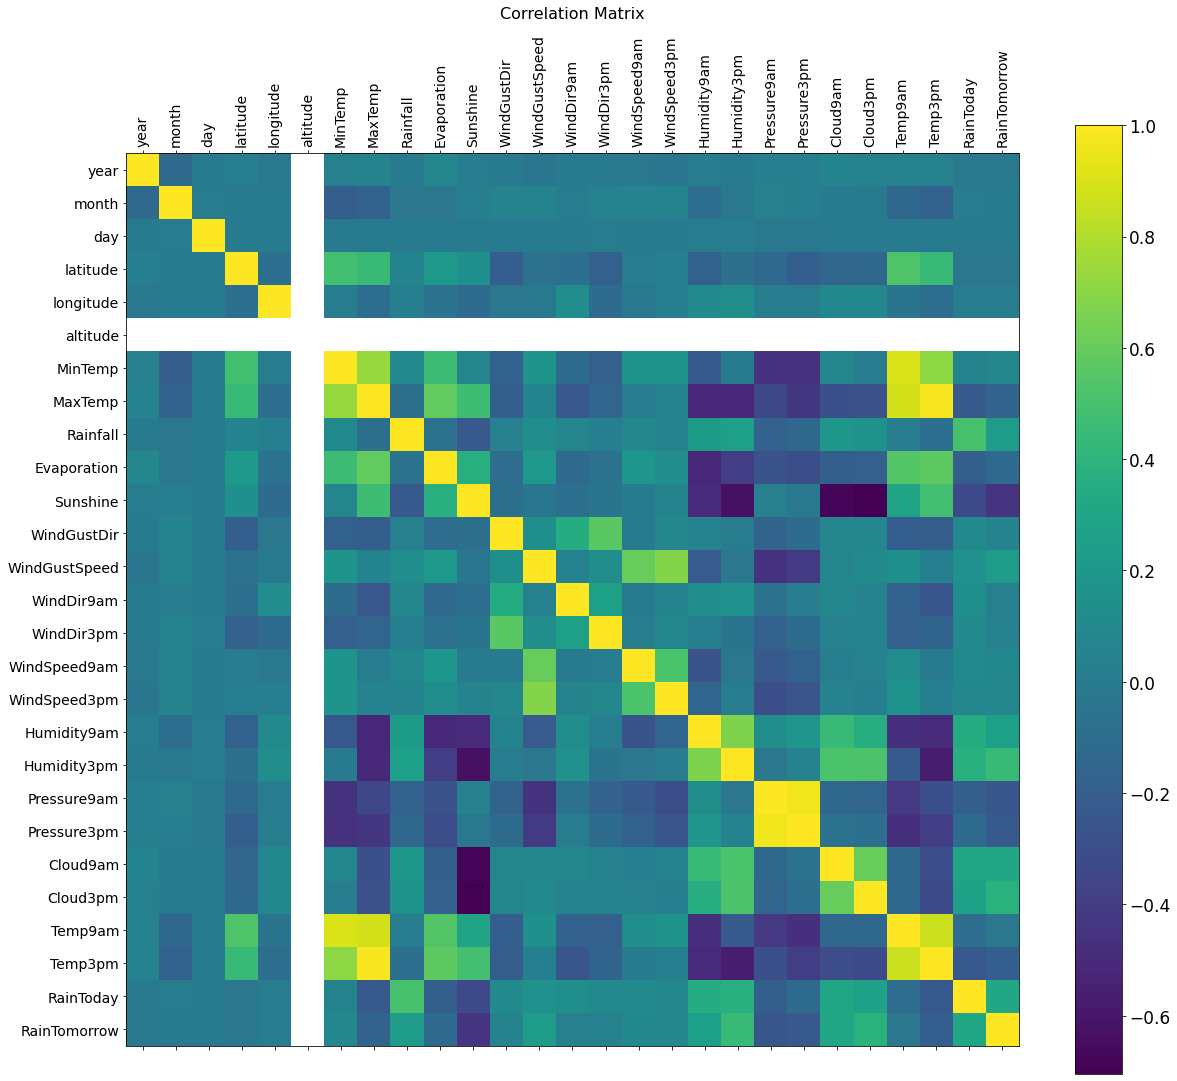

In [20]:
f = plt.figure(figsize=(20, 17))
plt.matshow(weather_df.corr(), fignum=f.number)
plt.xticks(range(weather_df.select_dtypes(['number']).shape[1]), weather_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(weather_df.select_dtypes(['number']).shape[1]), weather_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=17)
plt.title('Correlation Matrix', fontsize=16, pad=90);

## Split into input and outputs

## Design network

In [ ]:
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# split dataset into inputs and outputs
values = weather.values
X = values[:,0:20]
y = values[:,20]
# define the imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# define the model
lda = LinearDiscriminantAnalysis()
# define the modeling pipeline
pipeline = Pipeline(steps=[('imputer', imputer),('model', lda)])
# define the cross validation procedure
kfold = KFold(n_splits=3, shuffle=True, random_state=1)
# evaluate the model
result = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % result.mean())

We want to predict a boolean value ('Yes' or 'No') for the target variable **`RainTomorrow`**. In this case, we need to use a **classification** model, istead of a **regression** model, wich is used to predict real-world values (e.g. `Rainfall`).

In [ ]:
def create_model():
	model = Sequential()
	model.add(Dense(NEURONS, input_dim=60, activation='relu'))
	model.add(Dense(NEURONS, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model



#model = Sequential()
#model.add(LSTM(NEURONS, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, name='lstm1'))
#model.add(LSTM(NEURONS, name='lstm2'))
#model.add(Dense(1, activation='linear', name='output'))
#optimizer = Adam(lr=LEARNING_RATE)
#model.compile(loss=LOSS_FUNCTION, optimizer=optimizer)
#model.summary()

## Training

To be Continued...